
# Slide 15 - Class Visualization from Random Noise

This notebook **starts from pure random noise** and then **optimizes the pixels** to maximize the score for a chosen ImageNet class (e.g., `"dumbbell"`).  
It’s a simple, clean alternative to DeepDream: we target a **specific class** and use **gradient ascent on the input image**.
> ⚠️ The notebook uses a pretrained ImageNet model from `torchvision`. On first run it may **download weights**.


In [1]:

import math
import os
import time
import difflib
from pathlib import Path

import torch
import torch.nn.functional as F

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)


PyTorch: 2.5.1
Device: mps


In [2]:

# Loads a pretrained ImageNet classifier (ResNet-50 by default).
# Uses the modern weights API when available, with a backward-compatible fallback.

from typing import Optional, List

IMAGENET_MEAN_DEFAULT = [0.485, 0.456, 0.406]
IMAGENET_STD_DEFAULT  = [0.229, 0.224, 0.225]

try:
    from torchvision.models import resnet50, ResNet50_Weights
    weights = ResNet50_Weights.IMAGENET1K_V2  # high-accuracy weights
    model = resnet50(weights=weights).to(device).eval()
    categories: Optional[List[str]] = weights.meta.get("categories", None)
    mean = torch.tensor(weights.meta.get("mean", IMAGENET_MEAN_DEFAULT), dtype=torch.float32).view(1,3,1,1).to(device)
    std  = torch.tensor(weights.meta.get("std",  IMAGENET_STD_DEFAULT),  dtype=torch.float32).view(1,3,1,1).to(device)
    print("Loaded ResNet-50 with weights:", weights)
except Exception as e:
    # Fallback for older torchvision versions
    print("Weights API not available or failed to load. Falling back. Error:", e)
    from torchvision.models import resnet50
    model = resnet50(pretrained=True).to(device).eval()
    categories = None  # category names may be unavailable in very old versions
    mean = torch.tensor(IMAGENET_MEAN_DEFAULT, dtype=torch.float32).view(1,3,1,1).to(device)
    std  = torch.tensor(IMAGENET_STD_DEFAULT,  dtype=torch.float32).view(1,3,1,1).to(device)

# Helpful sanity
with torch.no_grad():
    # Create a tiny dummy to trigger lazy init on some backends
    _ = model(torch.randn(1,3,224,224, device=device))
print("Model ready.")


Loaded ResNet-50 with weights: ResNet50_Weights.IMAGENET1K_V2
Model ready.


In [3]:

def resolve_target_class(target, categories):
    """
    Resolve a class specifier to an integer class index.
    - If `target` is an int, return as-is.
    - If `target` is a string, try exact match, then substring match,
      then fuzzy (closest) match against ImageNet category names.
    """
    if isinstance(target, int):
        if not (0 <= target < 1000):
            raise ValueError(f"Integer class index {target} is out of ImageNet range [0, 999].")
        return target

    if not isinstance(target, str):
        raise TypeError("`target` must be an int or str.")

    if categories is None:
        raise RuntimeError(
            "ImageNet category names are unavailable in this torchvision version. "
            "Use an integer class index (0..999) instead."
        )

    name = target.strip().lower()
    # Exact match
    for i, cat in enumerate(categories):
        if name == cat.lower():
            return i

    # Substring match (e.g., 'dumbbell' in 'dumbbell')
    substr_hits = [(i, cat) for i, cat in enumerate(categories) if name in cat.lower()]
    if substr_hits:
        i, cat = substr_hits[0]
        print(f"Using substring match: '{target}' -> '{cat}' (idx={i})")
        return i

    # Fuzzy match (closest string)
    closest = difflib.get_close_matches(name, [c.lower() for c in categories], n=1, cutoff=0.0)
    if closest:
        best = closest[0]
        i = [c.lower() for c in categories].index(best)
        print(f"Using fuzzy match: '{target}' -> '{categories[i]}' (idx={i})")
        return i

    raise ValueError(f"Could not resolve class for '{target}'. Try an integer index (0..999).")


def tv_loss(x):
    """Total variation loss (anisotropic). Encourages spatial smoothness."""
    dh = x[..., 1:, :] - x[..., :-1, :]
    dw = x[..., :, 1:] - x[..., :, :-1]
    return (dh.abs().mean() + dw.abs().mean())


def to_display(img01):
    """Convert a [0,1] float tensor (B,C,H,W) on any device to a HxWxC uint8 numpy array."""
    img01 = img01.detach().clamp(0,1).to("cpu")
    img = (img01[0].permute(1,2,0).numpy() * 255.0).astype(np.uint8)
    return img


def show_image(img01, title=None):
    arr = to_display(img01)
    plt.figure(figsize=(4,4))
    plt.imshow(arr)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


In [ ]:

@torch.no_grad()
def _init_noise(h=224, w=224, seed=0, device="cpu"):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    return torch.rand(1, 3, h, w, generator=g, device=device)


def visualize_class(
    target,
    steps=512,
    img_size=224,
    seed=0,
    lr=0.1,
    tv_weight=1e-5,
    l2_weight=1e-4,
    jitter=8,
    save_every=64,
    save_dir="outputs",
    verbose=True,
):
    """
    Optimize pixels (starting from random noise) to maximize the target class logit.

    Args:
        target: str (class name like 'dumbbell') or int (0..999).
        steps: optimization steps (more -> better detail).
        img_size: square image size for ResNet-50 (224 is standard).
        seed: RNG seed for the initial noise.
        lr: learning rate for Adam.
        tv_weight: total variation strength.
        l2_weight: L2 penalty towards 0.5 gray.
        jitter: pixel jitter (int; random roll) to reduce tiling artifacts.
        save_every: save an intermediate frame every N steps.
        save_dir: where to save intermediate frames + final output.
        verbose: print progress.

    Returns:
        final_img01: image tensor in [0,1] of shape (1,3,H,W).
        target_idx: the integer class index used.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Initialize noise image in [0,1]
    img01 = _init_noise(h=img_size, w=img_size, seed=seed, device=device)
    show_image(img01, title=f"Starting noise (seed={seed})")  # show starting noise first

    # Parameterize the image directly in RGB [0,1]
    img01 = img01.clone().requires_grad_(True)

    # Resolve the target class index
    target_idx = resolve_target_class(target, categories)

    opt = torch.optim.Adam([img01], lr=lr)

    best_val = -1e9
    best_img = None
    t0 = time.time()

    for step in range(1, steps + 1):
        opt.zero_grad(set_to_none=True)

        x = img01
        # Jitter (random pixel roll) — helps reduce grid artifacts
        if jitter > 0:
            dh = int(torch.randint(-jitter, jitter + 1, (1,), device=device))
            dw = int(torch.randint(-jitter, jitter + 1, (1,), device=device))
            x = torch.roll(x, shifts=(dh, dw), dims=(2, 3))

        # Normalize for the classifier
        x_norm = (x - mean) / std

        logits = model(x_norm)
        class_logit = logits[0, target_idx]

        # Regularizers: encourage smooth & natural-ish images
        loss = -class_logit  # we *maximize* the class logit
        loss = loss + tv_weight * tv_loss(x) + l2_weight * ((x - 0.5) ** 2).mean()

        loss.backward()
        opt.step()

        # Clamp pixels back to [0,1]
        with torch.no_grad():
            img01.clamp_(0.0, 1.0)

        # Track best logit (not strictly necessary, but handy)
        with torch.no_grad():
            if class_logit.item() > best_val:
                best_val = class_logit.item()
                best_img = img01.detach().clone()

        # Save & print progress
        if verbose and (step % max(1, save_every) == 0 or step == 1):
            print(f"Step {step:4d}/{steps} | logit[{target_idx}] = {class_logit.item():.4f} | loss = {loss.item():.4f}")
            out_path = Path(save_dir) / f"step_{step:04d}.png"
            Image.fromarray(to_display(img01)).save(out_path)

    elapsed = time.time() - t0
    print(f"Done in {elapsed:.1f}s. Best logit[{target_idx}] = {best_val:.4f}")

    # Save final outputs
    final = best_img if best_img is not None else img01.detach()
    final_path = Path(save_dir) / f"final_{str(target).replace(' ', '_')}.png"
    Image.fromarray(to_display(final)).save(final_path)
    print("Final image saved to:", final_path)

    # Show the final result inline
    show_image(final, title=f"Final result for target: {target} (idx={target_idx})")

    return final, target_idx


In [15]:

# --- Parameters you might want to tweak ---
TARGET = "castle"   # You can also set an integer index [0..999]
STEPS = 100000           # 256-1024 is typical
IMG_SIZE = 224        # ResNet-50 default
SEED = 42             # random noise seed
LR = 0.001              # Adam learning rate
TV_WEIGHT = 1e-5      # total variation regularization strength
L2_WEIGHT = 1e-4      # L2 towards mid-gray 0.5
JITTER = 8            # random pixel roll
SAVE_EVERY = 256       # save intermediate frames every N steps
SAVE_DIR = "outputs"  # results directory (created if missing)
VERBOSE = True        # print progress


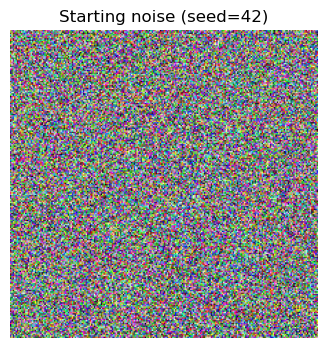

Step    1/100000 | logit[483] = -0.0588 | loss = 0.0588
Step  256/100000 | logit[483] = 9.3471 | loss = -9.3471
Step  512/100000 | logit[483] = 18.4918 | loss = -18.4918
Step  768/100000 | logit[483] = 25.7423 | loss = -25.7423
Step 1024/100000 | logit[483] = 29.0077 | loss = -29.0077
Step 1280/100000 | logit[483] = 30.5626 | loss = -30.5626
Step 1536/100000 | logit[483] = 31.1516 | loss = -31.1516
Step 1792/100000 | logit[483] = 35.0518 | loss = -35.0518
Step 2048/100000 | logit[483] = 36.4786 | loss = -36.4786
Step 2304/100000 | logit[483] = 36.2904 | loss = -36.2904
Step 2560/100000 | logit[483] = 34.5655 | loss = -34.5655
Step 2816/100000 | logit[483] = 37.5859 | loss = -37.5859
Step 3072/100000 | logit[483] = 37.3862 | loss = -37.3862
Step 3328/100000 | logit[483] = 36.6898 | loss = -36.6898
Step 3584/100000 | logit[483] = 39.9235 | loss = -39.9235
Step 3840/100000 | logit[483] = 39.8915 | loss = -39.8915
Step 4096/100000 | logit[483] = 38.4910 | loss = -38.4910
Step 4352/100000 |

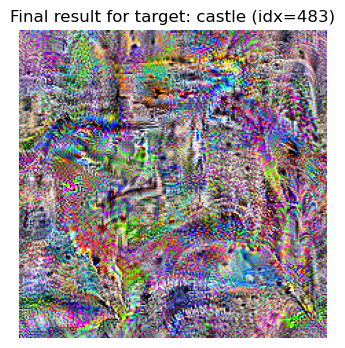

Used class index: 483
Resolved class name: castle


In [16]:

# Kick off the optimization from pure noise
final_img, class_idx = visualize_class(
    TARGET,
    steps=STEPS,
    img_size=IMG_SIZE,
    seed=SEED,
    lr=LR,
    tv_weight=TV_WEIGHT,
    l2_weight=L2_WEIGHT,
    jitter=JITTER,
    save_every=SAVE_EVERY,
    save_dir=SAVE_DIR,
    verbose=VERBOSE,
)

print(f"Used class index: {class_idx}")
if isinstance(TARGET, str):
    print("Resolved class name:", TARGET)
else:
    print("Resolved class index (int):", class_idx)
